# Workshop demo 2

 Creates an animation of the pressure-level wind data from BARRA-TA and BARRA-R sample data using netCDF4 and matplotlib.
 Wind vectors over 37 pressure levels.

 Code written for illustrating BARRA pressure-level data.

 Chun-Hsu Su, 19 January 2018
 The Bureau of Meteorology



In [101]:
import os, sys
import numpy as np
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

## Define methods needed to render the animation

In [102]:
def get_uv(j):
	"""
	Returns the lon,lat,pres,u,v values for a given pressure level
	identified by index j.
	"""
	_,a,b = modwind['uwind'].shape
	c = max(a,b)
	ivl = c/30
	x = datDict['lon'][::ivl]
	y = datDict['lat'][::ivl]
	u = datDict['uwind'][j,::ivl,::ivl]
	v = datDict['vwind'][j,::ivl,::ivl]
	p = datDict['prs'][j]
	return x,y,p,u,v

In [103]:
def update_quiver(j,ax,fig):
	"""
	Update the figure with the wind field at pressure level j.
	"""
	print("Plotting pressure level {:}".format(j))
	x,y,p,u,v = get_uv(j)
	Q.set_UVC(u,v)
	ax.set_title('Pressure level: {:3.3f} hPa'.format(p),fontsize=14)
	return Q

In [104]:
def init_quiver():
	"""
	Initialise the figure with the wind field at pressure level j = 0.
	"""
	global Q
	x,y,p,u,v = get_uv(0)
	Q = ax.quiver(x,y,u,v)
	ax.set_title('Pressure level: {:3.3f} hPa'.format(p),fontsize=14)
	#ax.set_xlabel('Longitude')
	#ax.set_ylabel('Latitude')
	return Q

## Main script

### Specify the data inputs

In [105]:
# datetime of file to animate, choose 2015/02/17 00 - 18 for sample data 
dtFile = datetime(2015,2,7,12,0)

In [106]:
# model string, choose BARRA_R or BARRA_TA for sample data
model = 'BARRA_R'

In [107]:
# define forecast hour to animate
forecastHour = 6

In [108]:
# basetime
dtBasetime = dtFile - timedelta(hours = forecastHour)

### Find the data

In [109]:
# Where are your sample data downloaded?
dataDirRoot = '/g/data/ma05/sample'
dataDirTemplate = os.path.join(dataDirRoot, '{model}/v1')

In [110]:
# iso 1806 time format string
isoFormat = '%Y%m%dT%H%MZ'

In [111]:
# file names have a specific structure eg:  BARRA_R/v1/forecast/spec/temp_scrn/2015/12/temp_scrn-fc-spec-PT10M-BARRA_R-v1-20151208T1800Z.nc
fnTemplate = os.path.join(dataDirTemplate, 'forecast', '{stream}', '{var}',\
                          '{year:04d}', '{month:02d}', '{var}-fc-{stream}-PT1H-{model}-v1-{basetimeStr}.nc')
uFn = fnTemplate.format(model=model, stream='prs', var='wnd_ucmp', year=dtBasetime.year,\
                              month = dtBasetime.month, basetimeStr = dtBasetime.strftime(isoFormat))
vFn = fnTemplate.format(model=model, stream='prs', var='wnd_vcmp', year=dtBasetime.year,\
                              month = dtBasetime.month, basetimeStr = dtBasetime.strftime(isoFormat))
topoFn = fnTemplate.format(model=model, stream='slv', var='topog', year=dtBasetime.year,\
                              month = dtBasetime.month, basetimeStr = dtBasetime.strftime(isoFormat))

In [112]:
# Depending on which model, specify plotting configurations
if model == "BARRA_T":
    # plotting domain extent: lonmin, lonmax, latmin, latmax
    domain = [143., 149., -44.185, -39.55]
    resolution = 'f' # boundary resolution

elif model == "BARRA_R":
    # Plot over Australia
    domain = [110.8, 158. , -45.6, -10.5]
    resolution = 'c'
    topoFn = topoFn.replace('PT1H', 'PT0H').replace('-fc-', '-an-').replace('forecast','analysis')
    

In [113]:
# Open the files and read the dimensions data
uFid = Dataset(uFn,'r')
vFid = Dataset(vFn,'r')
zFid = Dataset(topoFn,'r')
lat = uFid.variables['latitude'][:]
lon = uFid.variables['longitude'][:]
time = num2date(uFid.variables['time'][:], uFid.variables['time'].units)

In [114]:
# if missing input plotting domain then take the entire thing
if domain == None:
    domain = [lon.min(), lon.max(), lat.min(), lat.max()]

In [115]:
# create logical arrays of the filtered indices by lon, lat and time
lonIdxs = np.logical_and(lon>=domain[0], lon<=domain[1])
latIdxs = np.logical_and(lat>=domain[2], lat<=domain[3])
tIdxs = np.argwhere(time == dtFile).ravel()[0]
# truncate the lat lon arrays
latTrunc = lat[latIdxs]
lonTrunc = lon[lonIdxs]

In [116]:
vFid.variables.keys()

odict_keys(['latitude_longitude', 'time', 'pressure', 'latitude', 'longitude', 'forecast_period', 'forecast_reference_time', 'wnd_vcmp'])

In [117]:
# selectively read the wind data
uWnd = uFid.variables['wnd_ucmp'][tIdxs,:,latIdxs,lonIdxs]
vWnd = vFid.variables['wnd_vcmp'][tIdxs,:,latIdxs,lonIdxs]

In [118]:
# get the pressure level information
prs = uFid.variables['pressure'][:]
nPrs = len(prs)

In [119]:
# create data dict
datDict = {'lon':lonTrunc, 'lat':latTrunc, 'uwind':uWnd, 'vwind':vWnd, 'prs':prs}

### Plotting

In [120]:
# plotting configurations
dx = (domain[1]-domain[0])/8.0
dy = (domain[3]-domain[2])/10.0


{115.90000000000001: ([<matplotlib.lines.Line2D at 0x7f71e51c4390>],
  [Text(115.903,-46.072,'115.9°E')]),
 121.80000000000001: ([<matplotlib.lines.Line2D at 0x7f71e51fcb70>],
  [Text(121.809,-46.072,'121.8°E')]),
 127.70000000000002: ([<matplotlib.lines.Line2D at 0x7f71e51fcf60>],
  [Text(127.715,-46.072,'127.7°E')]),
 133.60000000000002: ([<matplotlib.lines.Line2D at 0x7f71e51d6390>],
  [Text(133.62,-46.072,'133.6°E')]),
 139.50000000000003: ([<matplotlib.lines.Line2D at 0x7f71e51d6780>],
  [Text(139.526,-46.072,'139.5°E')]),
 145.40000000000003: ([<matplotlib.lines.Line2D at 0x7f71e51d6b70>],
  [Text(145.432,-46.072,'145.4°E')]),
 151.30000000000004: ([<matplotlib.lines.Line2D at 0x7f71e51d6f60>],
  [Text(151.338,-46.072,'151.3°E')]),
 157.20000000000005: ([<matplotlib.lines.Line2D at 0x7f71e52a7390>],
  [Text(157.244,-46.072,'157.2°E')])}

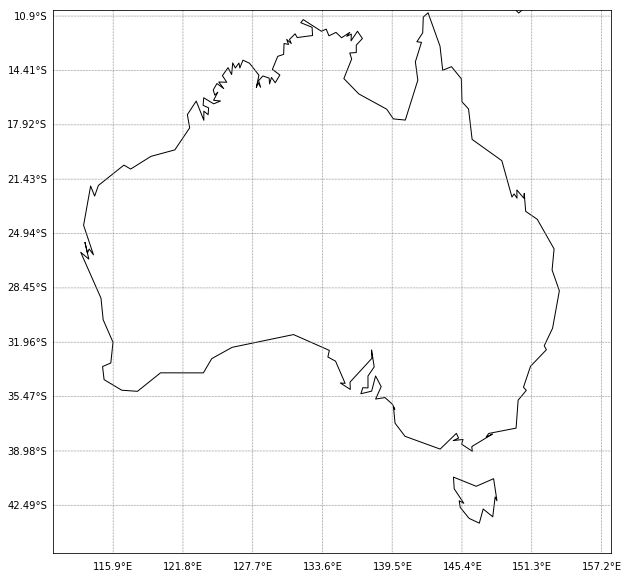

In [121]:
# set up subplot with coastline and basemap
fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
m = Basemap(llcrnrlon=domain[0], \
        llcrnrlat=domain[2], \
        urcrnrlon=domain[1], \
        urcrnrlat=domain[3], \
        projection='cyl', \
        fix_aspect=False, \
        resolution=resolution)
m.drawcoastlines()
m.drawparallels(np.arange(np.floor(domain[2]), np.ceil(domain[3]), dy), \
        labels=[1,0,0,0], linewidth=0.75, color='gray') #20
m.drawmeridians(np.arange(np.floor(domain[0]), np.ceil(domain[1]), dx), \
        labels=[0,0,0,1], linewidth=0.75,color='gray')


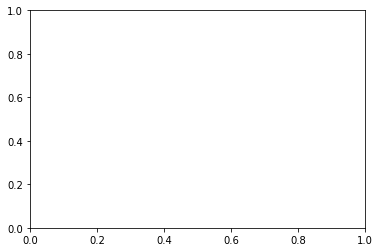

In [122]:
# plot the topography
# Plot the topography
top = ax.pcolorfast(zFid.variables['longitude'][:], \
        zFid.variables['latitude'][:], \
        zFid.variables['topog'][:], \
        vmin=0, \
        vmax=1000, \
        cmap=cm.Blues)
colorbar_frame = fig.add_axes([0.82,0.12,0.01,0.3])
plt.colorbar(top,label='Elevation [m]',cax=colorbar_frame)

In [123]:
# Plot the wind vector as frames
anim = FuncAnimation(fig, \
        update_quiver, \
        frames=np.arange(0,nPrs), \
        init_func=init_quiver, \
        interval=400, \
        fargs=(ax,fig), \
        repeat = False, \
        repeat_delay = 1000)

In [125]:
anim.to_html5_video()

NameError: name 'modwind' is not defined